In [1]:
# Importing Libraries

from textblob import TextBlob
import sys
import tweepy
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import nltk
import re
import json

from collections import Counter
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [2]:
# Authentication
# Make a config.json file from config.json.example
# Get the keys from https://developer.twitter.com

with open("config.json") as token:
    key=json.load(token)
consumerKey = key["consumerKey"]
consumerSecret = key["consumerSecret"]
accessToken = key["accessToken"]
accessTokenSecret = key["accessTokenSecret"]

auth = tweepy.OAuthHandler(consumerKey, consumerSecret)
auth.set_access_token(accessToken, accessTokenSecret)
api = tweepy.API(auth)

In [3]:
#Sentiment Analysis

def percentage(part,whole):
    return 100 * float(part)/float(whole) 

keyword = input("Please enter keyword or hashtag to search: ")
noOfTweet = int(input ("Please enter how many tweets to analyze: "))


tweets = tweepy.Cursor(api.search_tweets, q=keyword).items(noOfTweet)
positive  = 0
negative = 0
neutral = 0
polarity = 0
tweet_list = []
neutral_list = []
negative_list = []
positive_list = []

for tweet in tweets:
    tweet_list.append(tweet.text)
    analysis = TextBlob(tweet.text)
    score = SentimentIntensityAnalyzer().polarity_scores(tweet.text)
    neg = score['neg']
    neu = score['neu']
    pos = score['pos']
    comp = score['compound']
    polarity += analysis.sentiment.polarity
    
    if neg > pos:
        negative_list.append(tweet.text)
        negative += 1

    elif pos > neg:
        positive_list.append(tweet.text)
        positive += 1
    
    elif pos == neg:
        neutral_list.append(tweet.text)
        neutral += 1

positive = percentage(positive, noOfTweet)
negative = percentage(negative, noOfTweet)
neutral = percentage(neutral, noOfTweet)
polarity = percentage(polarity, noOfTweet)
positive = round(positive,1)
negative = round(negative,1)
neutral = round(neutral,1)

Please enter keyword or hashtag to search: Messi
Please enter how many tweets to analyze: 1000


In [4]:
#Number of Tweets (Total, Positive, Negative, Neutral)
tweet_list = pd.DataFrame(tweet_list)
neutral_list = pd.DataFrame(neutral_list)
negative_list = pd.DataFrame(negative_list)
positive_list = pd.DataFrame(positive_list)
print("total number: ",len(tweet_list))
print("positive number: ",len(positive_list))
print("negative number: ", len(negative_list))
print("neutral number: ",len(neutral_list))

total number:  1000
positive number:  251
negative number:  199
neutral number:  550


In [5]:
#Removing Duplicate Tweets
tweet_list.drop_duplicates(inplace = True)

In [6]:
tweet_list

,0
0,Btw Messi did not deserve Ballon D’Or. Just no...
1,Mais uma bola de ouro roubada pro Messi! https...
2,RT @PortalMessi: Os fotógrafos pediram para qu...
3,RT @Paul_Tenorio: Messi marcó 0 goles a Madrid...
4,RT @CrewsMat10: Messi won the final Ballon d’O...
...,...
987,RT @MrTOTO8097: Ti patnè kite di depi Messi pr...
988,Messi📝 : \nQue hermosa sorpresa me diste anoch...
992,RT @FerIglesias: Mis sinceras felicitaciones a...
993,Essa bola de ouro do Messi vai fazer mais da m...


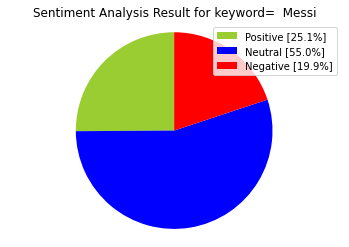

In [7]:
#Creating PieCart

labels = ['Positive ['+str(positive)+'%]' , 'Neutral ['+str(neutral)+'%]','Negative ['+str(negative)+'%]']
sizes = [positive, neutral, negative]
colors = ['yellowgreen', 'blue','red']
patches, texts = plt.pie(sizes,colors=colors, startangle=90)
plt.style.use('default')
plt.legend(labels)
plt.title("Sentiment Analysis Result for keyword=  "+keyword+"" )
plt.axis('equal')
plt.show()

In [8]:
#Cleaning Text (RT, Punctuation etc)
tw_list = pd.DataFrame(tweet_list)
tw_list["text"] = tw_list[0]

#Removing RT, Punctuation etc
remove_rt = lambda x: re.sub('RT @\w+: '," ",x)
rt = lambda x: re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",x)
tw_list["text"] = tw_list.text.map(remove_rt).map(rt)
tw_list["text"] = tw_list.text.str.lower()
tw_list.head(10)

,0,text
0,Btw Messi did not deserve Ballon D’Or. Just no...,btw messi did not deserve ballon d or just no...
1,Mais uma bola de ouro roubada pro Messi! https...,mais uma bola de ouro roubada pro messi
2,RT @PortalMessi: Os fotógrafos pediram para qu...,os fot grafos pediram para que antonela sa ss...
3,RT @Paul_Tenorio: Messi marcó 0 goles a Madrid...,messi marc 0 goles a madrid y atleti en liga...
4,RT @CrewsMat10: Messi won the final Ballon d’O...,messi won the final ballon d or of the 2000s ...
5,RT @brfootball: Seven golden goats at the Eiff...,seven golden goats at the eiffel tower for me...
6,@FERDINANDHAHAAH E o messi batendo Record na l...,e o messi batendo record na la liga
7,RT @nostalgiafutbo1: 7 Balones de Oro antes......,7 balones de oro antes leo messi 1992
8,RT @AllanDr_: Messi-Pedri. La fierté. Le regar...,messi pedri la fiert le regard de grand fr...
9,RT @ClearlyMessi: In conclusion both Messi and...,in conclusion both messi and lewandowski were...


In [9]:
#Calculating Negative, Positive, Neutral and Compound values

tw_list[['polarity', 'subjectivity']] = tw_list['text'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))
for index, row in tw_list['text'].iteritems():
    score = SentimentIntensityAnalyzer().polarity_scores(row)
    neg = score['neg']
    neu = score['neu']
    pos = score['pos']
    comp = score['compound']
    if neg > pos:
        tw_list.loc[index, 'sentiment'] = "negative"
    elif pos > neg:
        tw_list.loc[index, 'sentiment'] = "positive"
    else:
        tw_list.loc[index, 'sentiment'] = "neutral"
    tw_list.loc[index, 'neg'] = neg
    tw_list.loc[index, 'neu'] = neu
    tw_list.loc[index, 'pos'] = pos
    tw_list.loc[index, 'compound'] = comp

tw_list.head(10)

,0,text,polarity,subjectivity,sentiment,neg,neu,pos,compound
0,Btw Messi did not deserve Ballon D’Or. Just no...,btw messi did not deserve ballon d or just no...,0.800000,0.400000,positive,0.067,0.833,0.100,0.2023
1,Mais uma bola de ouro roubada pro Messi! https...,mais uma bola de ouro roubada pro messi,0.000000,0.000000,neutral,0.000,1.000,0.000,0.0000
2,RT @PortalMessi: Os fotógrafos pediram para qu...,os fot grafos pediram para que antonela sa ss...,0.000000,0.000000,negative,0.099,0.901,0.000,-0.2960
3,RT @Paul_Tenorio: Messi marcó 0 goles a Madrid...,messi marc 0 goles a madrid y atleti en liga...,0.000000,0.000000,negative,0.095,0.905,0.000,-0.2960
4,RT @CrewsMat10: Messi won the final Ballon d’O...,messi won the final ballon d or of the 2000s ...,0.083333,0.777778,positive,0.000,0.748,0.252,0.8126
5,RT @brfootball: Seven golden goats at the Eiff...,seven golden goats at the eiffel tower for me...,0.300000,0.500000,neutral,0.000,1.000,0.000,0.0000
6,@FERDINANDHAHAAH E o messi batendo Record na l...,e o messi batendo record na la liga,0.000000,0.000000,neutral,0.000,1.000,0.000,0.0000
7,RT @nostalgiafutbo1: 7 Balones de Oro antes......,7 balones de oro antes leo messi 1992,0.000000,0.000000,neutral,0.000,1.000,0.000,0.0000
8,RT @AllanDr_: Messi-Pedri. La fierté. Le regar...,messi pedri la fiert le regard de grand fr...,0.500000,1.000000,positive,0.000,0.864,0.136,0.4588
9,RT @ClearlyMessi: In conclusion both Messi and...,in conclusion both messi and lewandowski were...,0.500000,0.500000,neutral,0.000,1.000,0.000,0.0000


In [10]:
#Function for counting values in single columns

def count_values_in_column(data,feature):
    total=data.loc[:,feature].value_counts(dropna=False)
    percentage=round(data.loc[:,feature].value_counts(dropna=False,normalize=True)*100,2)
    return pd.concat([total,percentage],axis=1,keys=['Total','Percentage'])

In [11]:
#Count_values for sentiment
count_values_in_column(tw_list,"sentiment")

,Total,Percentage
neutral,368,53.57
positive,184,26.78
negative,135,19.65


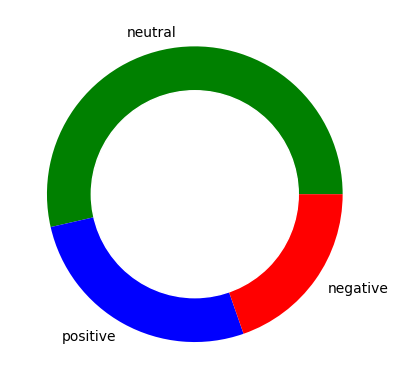

In [12]:
pichart = count_values_in_column(tw_list,"sentiment")
names= pichart.index
size=pichart["Percentage"]

my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(size, labels=names, colors=['green','blue','red'])
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [13]:
#Calculating tweet's length and word count
tw_list['text_len'] = tw_list['text'].astype(str).apply(len)
tw_list['text_word_count'] = tw_list['text'].apply(lambda x: len(str(x).split()))

In [14]:
round(pd.DataFrame(tw_list.groupby("sentiment").text_len.mean()),2)

,text_len
sentiment,
negative,94.24
neutral,84.07
positive,98.49


In [15]:
round(pd.DataFrame(tw_list.groupby("sentiment").text_word_count.mean()),2)

,text_word_count
sentiment,
negative,18.12
neutral,15.31
positive,18.09


In [16]:
#Most Used Words
most_used_words = pd.DataFrame(Counter(" ".join(tw_list["text"]).split()).most_common(),columns=["word","count"])
for i in most_used_words["word"]:
    if len(i)<4:
        most_used_words= most_used_words[most_used_words.word != i]
most_used_words.reset_index(drop=True,inplace=True)
most_used_words.head(10)

,word,count
0,messi,613
1,ballon,95
2,lionel,54
3,ronaldo,49
4,lewandowski,42
5,para,39
6,that,33
7,ballondor,30
8,cristiano,29
9,this,28
